# Spatial Temporal Graph Convolutional Network
このnotebookではSpatial Temporal Graph Convolional Network (ST-GCN)の基礎の部分を噛み砕いて理解していきます．<br>
[PyTorch実装で理解するGraph Convolutional Network](https://zenn.dev/hash_yuki/articles/cb008a7c19e917)でGCNの基礎知識について理解しておくことを推奨します．<br>

## 時系列グラフ（3次元グラフ）
spatial temporal（時空間）とあるように，GCNの畳み込みを時間方向に拡張したモデルです．<br>
GCNで扱っていたグラフは2次元グラフでしたが，ST-GCNでは時系列情報も持った3次元グラフです（Fig.1）．<br>
この時フレーム間のノードの接続方法はいくつか考えられますが，とりあえずは簡単のため同一のノードを結ぶエッジとします．<br>
3次元グラフも2次元グラフ同様$\mathcal{G}=\{\mathcal{V,E}\}$と表現できます．<br>
この時ノードの集合$\mathcal{V}=\{v_{it}\mid i = 1, \ldots,V;i = 1, \ldots,T\}$であり，エッジに関しては一旦空間方向だけの集合$\mathcal{E}=\{e_{ij}\}$で定義しておきます．<br>
理由としては時間方向のエッジは同一ノードを繋ぐだけなので，隣接行列を使わなくても普通の畳み込みで対応できるからです．この後の実装などで理解
できると思うので一旦スルーしましょう．<br>
<img src="asset/spatial-temporal-graph-convolutional-network/st-graph.png" width="512"><br>
*Fig.1 グラフ構造*<br>
<br>
ここで，プログラミングで扱えるようにするためFig.1の3次元グラフをtensorに置き換えます．<br>
2次元の特徴量は$\mathbf{X}_t=[\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3,\mathbf{x}_4,\mathbf{x}_5]^\top$として表現できることは[前回](https://zenn.dev/hash_yuki/articles/cb008a7c19e917)理解しましたね．<br>
これをさらに3次元方向に重ねて$\mathbf{X}=\{\mathbf{X}_t\}(\in\mathbb{R}^{T\times V\times C})$と表現できます（Fig.2）．<br>
<img src="asset/spatial-temporal-graph-convolutional-network/feature_matrix.png" width="512"><br>
*Fig.2 グラフ特徴と隣接行列*<br>
<br>

## データ作成
せっかくなので，APIを利用した姿勢推定からデータを作成してみましょう．<br>
ここではグーグル先生が公開してくれている[MediaPipe](https://google.github.io/mediapipe/)を利用してみることとします．<br>
裏で色々手こずりました．<br>
Apple siliconは公式には対応していないみたいです．<br>
Apple silicon環境の方は`pip install mediapipe-silicon`それ以外の方は`pip install mediapipe`でインストールしてみてください！<br>
動画はvideoACから拝借しました(https://video-ac.com/video/45)．<br>
手元で試す際は適当な動画を`asset\video.py`に保存して使用してください．<br>
<br>

事前準備が長くなりましたが，早速姿勢推定をしていきます．<br>
基本的には公式の[Solutions](https://google.github.io/mediapipe/solutions/pose#python-solution-api)に基づいて実装するので詳しい説明は割愛します．<br>

In [84]:
import cv2
import numpy as np
import mediapipe as mp

# 今回使うグラフのセッティング
num_node = 17
E = [[15,13],[13,11],[16,14],[14,12],[11,12],[5,11],
     [6,12],[5,6],[5,7], [6,8],[7,9],[8,10],[1,2],
     [0,1],[0,2],[1,3],[2,4],[3,5],[4,6]]
reduced_keypoints = [0,2,5,7,8,11,12,13,14,15,16,23,24,25,26,27,28] # 関節数が多すぎてごちゃつくので必要な分だけピックアップ

# APIで推定した座標を3次元特徴量に変換する関数
def make_spatial_feature_mx(hand_landmarks, width, height):
    spatial_mx = []
    for i, lm in enumerate(hand_landmarks.landmark):
        if i in reduced_keypoints:
            x = lm.x * width
            y = lm.y * height
            spatial_mx.append([x, y])
    spatial_mx = np.array(spatial_mx)
    return spatial_mx   # shape (V, C)
    
# videoの読み込み
cap = cv2.VideoCapture("asset/spatial-temporal-graph-convolutional-network/video.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

X = []
#pose推定の設定
mp_pose = mp.solutions.pose
with mp_pose.Pose(
    min_detection_confidence=0.5,   
    min_tracking_confidence=0.5) as pose:
    
    idx = 0
    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx * fps) # 動きがわかりやすいように1秒ごと取得
        success, image = cap.read()
        if not success:
            break

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        X_t = make_spatial_feature_mx(results.pose_landmarks, width, height)    # 各フレームでの特徴行列を作成
        X.append(X_t)   # 時間方向に追加する
        idx += 1
        
X = np.array(X)
X.shape # T V C

(6, 17, 2)

ポーズ推定が終わったので，可視化してみましょう．

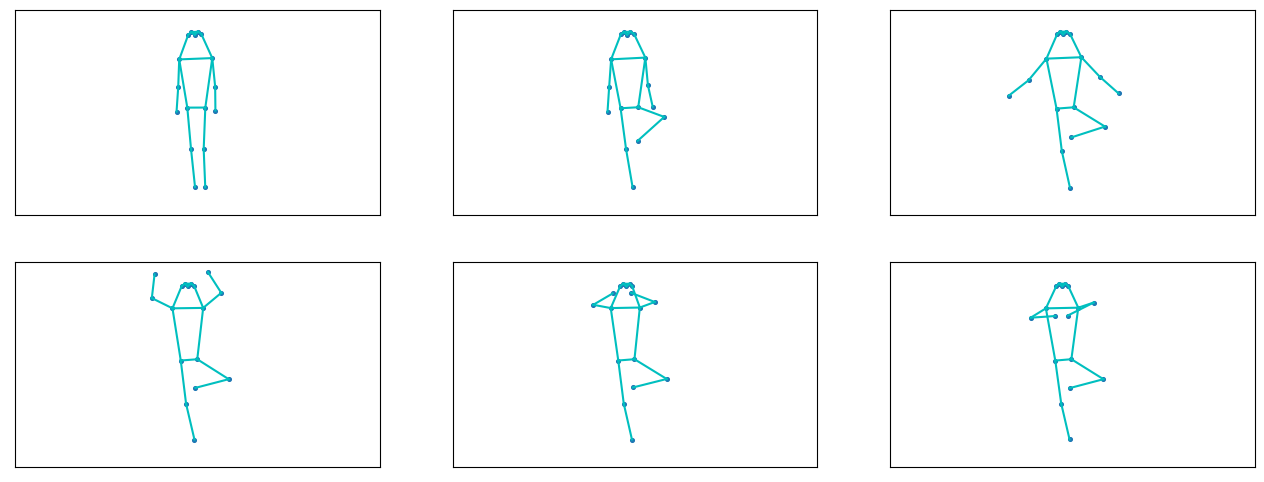

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt
        
fig, ax = plt.subplots(2, 3, figsize=(16.0, 6.0) )
for i in range(6):
    r = i // 3
    c = i % 3
    # エッジを描画
    for e in E:
        ax[r,c].plot([X[i, e[0], 0], X[i, e[1], 0]], [X[i, e[0], 1], X[i, e[1], 1]], "c")
    # ノードを描画
    ax[r,c].scatter(X[i, :, 0], X[i, :, 1], s=7)
    # その他設定
    ax[r,c].set_xlim([0, width])
    ax[r,c].set_ylim([0, height])
    ax[r,c].set_aspect('equal', 'box')
    ax[r,c].set_xticks([])
    ax[r,c].set_yticks([])
    ax[r,c].invert_yaxis()


どうでしょうか？ヨガのポーズをしているグラフが描画できましたね．<br>
このようにST-GCNなどのGraphベースの行動認識では前段の姿勢推定が必須です．<br>
今回のようにAPIを活用すると比較的簡単に実装できますし，より精度や速度を求めてGitHubなどに上がっているソースから実装してもいいですね．<br>
<br>
ついでに前回同様，隣接行列$\mathbf{A}$と正規化した隣接行列$\mathbf{D}^{-\frac{1}{2}}\mathbf{A}\mathbf{D}^{-\frac{1}{2}}$も定義してしまいます．

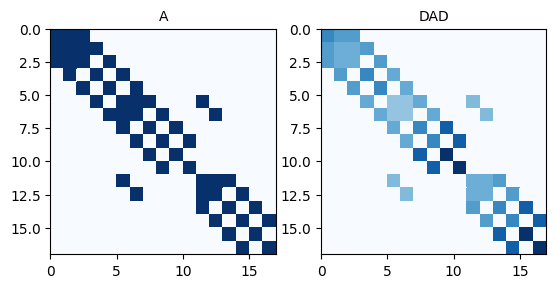

In [85]:
def edge2mat(E, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in E:
        A[j, i] = 1
    return A

def get_D(A, pow=-1):
    d_ii = np.sum(A, 0)
    D = np.zeros_like(A)
    for i in range(len(A)):
        D[i, i] = d_ii[i]**(pow)
    return D

reversed_E = [[j, i] for [i, j] in E]
I = [[i, i] for i in range(num_node)] 
new_E = E + reversed_E + I

# 隣接行列の作成
A = edge2mat(new_E, num_node)  # ノードの数は5

# DAD
D = get_D(A,pow=-0.5)
DAD = D @ A @ D

fig, ax = plt.subplots(1, 2)
ax[0].pcolor(A, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('A', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(DAD, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('DAD', fontsize=10)
ax[1].invert_yaxis()

今回はこのような6フレーム分の時系列姿勢データ$\mathbf{X}$とその隣接行列$\mathbf{D}^{-\frac{1}{2}}\mathbf{A}\mathbf{D}^{-\frac{1}{2}}$を例に，ST-GCNを理解していきましょう！

## ST-GCN
ただのGCNでもノードとか隣接行列とかいっぱいあって難しかったのに，時空間に畳み込むなんて複雑そう．．と思ったかもしれませんが，GCNさえ理解できていればST-GCNは意外と単純です．<br>
まずは図を使いながら理解していきましょう！<br>
時空間の畳み込みと言いつつ，実は空間と時間は別の処理で畳み込みます．<br>

### 空間畳み込み
まず，空間方向の畳み込みは[前回](https://zenn.dev/hash_yuki/articles/cb008a7c19e917)のGCNを使用します．<br>
このとき，時間方向を一気に扱いたいため，実装上は1x1Convを用いるので，それに準じて図示したものがFig.3となります．<br>
理解が難しかった人は前回の記事に戻ってFig.8あたりを確認してみてください．<br>
どうですか？処理自体は全く同じで，入力に時間方向の情報が増えただけですね！<br>
<img src="asset/spatial-temporal-graph-convolutional-network/spatial_gcn.png" width="512"><br>
*Fig.3 空間方向の畳み込み*<br>
<br>
ではここまでの処理を実装していきます.


In [95]:
import torch
from torch import nn
from einops import rearrange

X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = rearrange(X_tensor, "T V C -> C T V")    # チャネルファースト
A_tensor = torch.tensor(A, dtype=torch.float32)
D_tensor = torch.tensor(D, dtype=torch.float32)

# 重みをConvとして設定
in_channels = 2      # x座標とy座標なので
out_channels = 8     # 適当です

spatial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1conv

# 行列計算
XW = spatial_conv(X_tensor)
# einsumを使います.
# einsum使いたくないのであれば，for文で回すか，隣接行列をフレーム分拡張するなどの実装もできると思います．
spatial_X_tensor = torch.einsum('CTV,VW->CTW', XW, D_tensor @ A_tensor @ D_tensor)

print(f"入力のサイズ：{X_tensor.size()}")
print(f"出力のサイズ：{spatial_X_tensor.size()}")

入力のサイズ：torch.Size([2, 6, 17])
出力のサイズ：torch.Size([8, 6, 17])


今回は3次元データのため可視化は省略しましたが，特徴量次元が2→8に増えていることが確認できます．<br>
これは畳み込みと隣接行列によってフレームごと隣接ノードを畳み込めたことを示しています．<br>

## 時間畳み込み
次にフレーム間（時間方向）の畳み込みをしていきます．<br>
空間方向ではノードによって隣接ノードの数が2つだったり3つだったりと異なっていましたよね？<br>
では時間方向はどうでしょう？どのノードも前後のフレームとの接続しかないので2つだけですね．<br>
つまりGCNのように隣接行列を使わなくても，Fig.4のように画像みたいに畳み込むことができます．<br>
これが最初に空間方向のエッジしか定義しなかった理由です(エッジはあるんだけど，定義しなくても自明的なイメージですね)．<br>
少し噛み砕くと，ノード方向に1，時間方向に$\tau$のカーネルを用いてノード方向のストライドは1にして畳み込むと，ノードごとに時間方向が集約できます．<br>
実際の実装ではpaddingを使ったり，時間方向のstrideを2にしてpoolignを兼ねた畳み込みのようにしたりなどの工夫がされています．<br>
<img src="asset/spatial-temporal-graph-convolutional-network/temporal_conv.png" width="512"><br>
*Fig.3 空間方向の畳み込み*<br>
<br>

では先ほどの空間畳み込みで集約された出力を時間方向に畳み込んでみましょう．

In [93]:
t_kernel = 3    # 何フレーム分畳み込むかの設定
t_stride = 1    # 時間方向のストライド
padding = ((t_kernel - 1) // 2, 0)  # 入力と同じサイズの出力にするために
temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(t_kernel, 1), stride=(t_stride, 1), padding=padding)

temporal_X_tensor = temporal_conv(spatial_X_tensor)

print(f"入力サイズ：{temporal_X_tensor.size()}")
print(f"出力サイズ：{temporal_X_tensor.size()}")

入力サイズ：torch.Size([8, 6, 17])
出力サイズ：torch.Size([8, 6, 17])


実装でみてみると時空間の畳み込みも思ったよりシンプルだったと思います．<br>
ST-GCNではこの時間方向と空間方向の畳み込みを繰り返すことで時系列情報を抽出しています．<br>
使い方的には画像のCNNと同じですね！
<br>
## PyTroch Layerを作ってみる
STBlockとしてレイヤーを作成してみましょう！<br>
（公式の実装とは異なります）

In [ ]:
class STBlock(nn.Module):
    def __init__(self, in_features, out_features, t_kernel, t_stride):
        super(STBlock, self).__init__()
        # args
        self.in_features = in_features
        self.out_features = out_features
        padding = ((t_kernel - 1) // 2, 0)
        
        # layer
        self.spatial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(t_kernel, 1), stride=(t_stride, 1), padding=padding)
        
    def forward(self, input, adj):
        """
        Args:
            input (Tensor): graph feature
                            input.size() = (N, C, V, T)
            adj (Tensor): normalized adjacency matrix.
                          e.g. DAD or DA
                          input.size() = (V, V)
        Returns:
            Tensor: out.size() = (N, C_out, V, T)
        """
        XW = self.spatial_conv(input)
        spatial_feature = torch.einsum('NCTV,VW->NCTW', XW, adj)
        temporal_feature = self.temporal_conv(spatial_feature)
        return temporal_feature